### Initializing an empty dataframe with targeted columns

In [178]:
import pandas as pd

df = pd.DataFrame(columns=["datetime", "energy_consumed_MW"])
print(len(df.columns))

2


#### Function to rename columns to the same consistent names and concat

In [179]:
def concat(filePath):
    global df
    data = pd.read_csv(filePath)

    data = data.rename(columns={data.columns[0]: "datetime", data.columns[1]: "energy_consumed_MW"})

    data = data.dropna()

    df = pd.concat([df, data], ignore_index=True)

In [180]:
# Get the names of all data files
import os
dir_path = "data"
files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
print(files)

['PJMW_hourly.csv', 'PJM_Load_hourly.csv', 'DAYTON_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'FE_hourly.csv', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DEOK_hourly.csv', 'DUQ_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv']


In [181]:
# Concat all data together

for file in files:
    concat(f"data/{file}")
len(df)

/var/folders/p_/s7j3yg812t31y_tmxgj5x9gw0000gn/T/ipykernel_992/1393776955.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, data], ignore_index=True)


1090167

#### EDA

<Axes: >

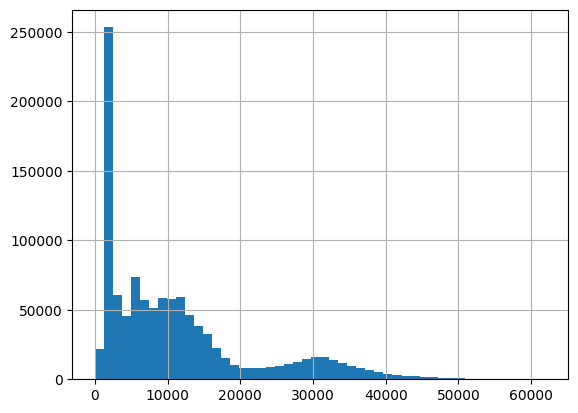

In [182]:
import matplotlib.pyplot as plt

df["energy_consumed_MW"].hist(bins=50)

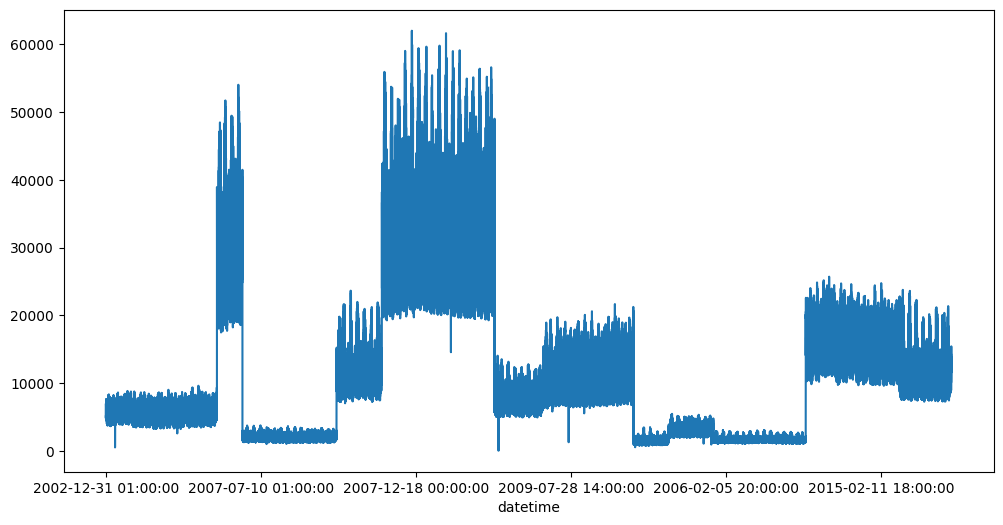

In [183]:
df.set_index("datetime")["energy_consumed_MW"].plot(figsize=(12,6))
df["datetime"] = pd.to_datetime(df["datetime"])

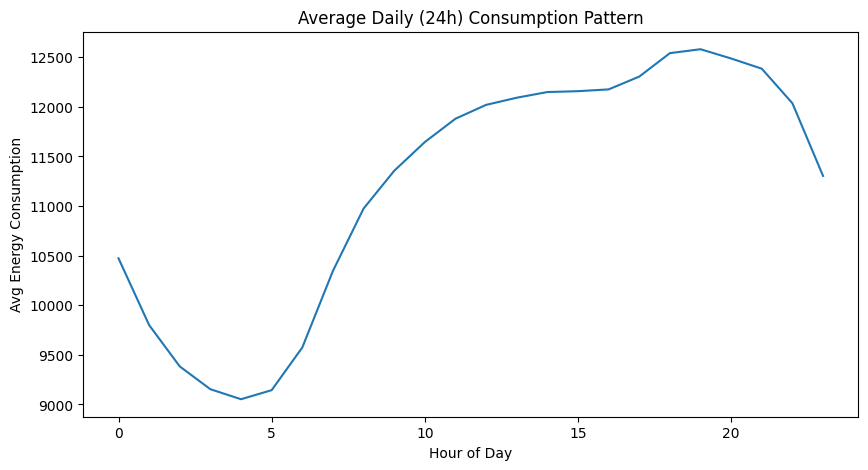

In [184]:
df["hour_of_day"] = df["datetime"].dt.hour

hourly_pattern = df.groupby("hour_of_day")["energy_consumed_MW"].mean()

hourly_pattern.plot(kind="line", figsize=(10,5))
plt.xlabel("Hour of Day")
plt.ylabel("Avg Energy Consumption")
plt.title("Average Daily (24h) Consumption Pattern")
plt.show()

In [185]:
df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['datetime'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6])

In [186]:
df.head()

,datetime,energy_consumed_MW,hour_of_day,day_of_week,month,is_weekend
0,2002-12-31 01:00:00,5077.0,1,1,12,False
1,2002-12-31 02:00:00,4939.0,2,1,12,False
2,2002-12-31 03:00:00,4885.0,3,1,12,False
3,2002-12-31 04:00:00,4857.0,4,1,12,False
4,2002-12-31 05:00:00,4930.0,5,1,12,False


In [187]:
for col in df.columns:
    if col in("datetime", "hour_of_day", "energy_consumed_MW"):
        continue
    print(df[col].value_counts(normalize=True)*100)

day_of_week
3    14.294232
2    14.294140
1    14.289829
0    14.289829
5    14.283041
4    14.276803
6    14.272125
Name: proportion, dtype: float64
month
7     8.872035
5     8.735359
6     8.585657
1     8.462373
3     8.453017
12    8.325330
10    8.323404
4     8.319368
8     8.234518
11    8.056105
9     7.925391
2     7.707443
Name: proportion, dtype: float64
is_weekend
False    71.444834
True     28.555166
Name: proportion, dtype: float64


In [188]:
import pandas as pd

# Ensure datetime is sorted
df = df.sort_values('datetime')
df = df.reset_index(drop=True)

# DAILY lags (assumes df is daily frequency)
daily_lags = [1, 7, 14]
for lag in daily_lags:
    df[f'lag_{lag}_day'] = df['energy_consumed_MW'].shift(lag)

# HOURLY lags (assumes df is hourly frequency)
hourly_lags = [1, 2, 24]
for lag in hourly_lags:
    df[f'lag_{lag}_hour'] = df['energy_consumed_MW'].shift(lag)

df = df.dropna()

In [189]:
print(len(df))

1090143


In [ ]:
# Ensure datetime is sorted
df = df.sort_values('datetime').reset_index(drop=True)

# --- DAILY features (assumes daily frequency) ---
daily_lags = [1, 7, 14]
for lag in daily_lags:
    df[f'lag_{lag}_day'] = df['energy_consumed_MW'].shift(lag)
    df[f'roll_mean_{lag}_day'] = df['energy_consumed_MW'].shift(1).rolling(window=lag).mean()
    if lag != 1:
        df[f'roll_std_{lag}_day'] = df['energy_consumed_MW'].shift(1).rolling(window=lag).std()

# --- HOURLY features (assumes hourly frequency) ---
hourly_lags = [1, 2, 24]
for lag in hourly_lags:
    df[f'lag_{lag}_hour'] = df['energy_consumed_MW'].shift(lag)
    df[f'roll_mean_{lag}_hour'] = df['energy_consumed_MW'].shift(1).rolling(window=lag).mean()
    if lag != 1:
        df[f'roll_std_{lag}_hour'] = df['energy_consumed_MW'].shift(1).rolling(window=lag).std()

# Drop initial rows with NaNs caused by lags/rolling
df = df.dropna()

In [191]:
print(len(df))

1090119


In [192]:
df.head()

,datetime,energy_consumed_MW,hour_of_day,day_of_week,month,is_weekend,lag_1_day,lag_7_day,lag_14_day,lag_1_hour,...,roll_mean_1_day,roll_mean_7_day,roll_std_7_day,roll_mean_14_day,roll_std_14_day,roll_mean_1_hour,roll_mean_2_hour,roll_std_2_hour,roll_mean_24_hour,roll_std_24_hour
24,1998-04-03 01:00:00,20905.0,1,4,4,False,22795.0,28891.0,30140.0,22795.0,...,22795.0,27843.714286,2791.129563,28861.500000,2188.247235,22795.0,24072.5,1806.657826,26587.333333,4081.905572
25,1998-04-03 02:00:00,19974.0,2,4,4,False,20905.0,29438.0,30017.0,20905.0,...,20905.0,26702.857143,3756.782508,28201.857143,3010.610285,20905.0,21850.0,1336.431816,26571.250000,4104.379837
26,1998-04-03 03:00:00,19215.0,3,4,4,False,19974.0,30656.0,30118.0,19974.0,...,19974.0,25350.857143,4275.544271,27484.500000,3669.285589,19974.0,20439.5,658.316413,26557.583333,4126.648329
27,1998-04-03 04:00:00,19488.0,4,4,4,False,19215.0,29696.0,30175.0,19215.0,...,19215.0,23716.428571,4092.399005,26705.714286,4187.763722,19215.0,19594.5,536.694047,26533.125000,4169.941479
28,1998-04-03 05:00:00,19928.0,5,4,4,False,19488.0,28080.0,29989.0,19488.0,...,19488.0,22258.142857,3359.675849,25942.357143,4471.165768,19488.0,19351.5,193.040151,26525.333333,4183.466034


In [194]:
df.to_csv("finalData.csv")